<a href="https://colab.research.google.com/github/ariahosseini/DeepML/blob/main/002_TensorFlow_Proj_Two_CNN_TransferLearning_DogsVsCats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# util
from google.colab import drive
import itertools
import numpy as np
import glob
import os
import shutil
from random import (randint, sample, choice)
from IPython.display import Image
# sklearn
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import (Sequential, load_model)
from tensorflow.keras.layers import (Dense, Activation, Flatten,
                                     BatchNormalization, Conv2D,
                                     MaxPool2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import (CategoricalCrossentropy, SparseCategoricalCrossentropy,
                                      categorical_crossentropy, binary_crossentropy)
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import imagenet_utils
# matplotlib
import matplotlib.pyplot as plt

In [ ]:
# Set GPU
physical_devices = tf.config.experimental.list_physical_devices(device_type='GPU')
print("No. GPUs available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(device=physical_devices[0], enable=True)
# Mount google drive
drive.mount('/content/drive')

No. GPUs available:  1
Mounted at /content/drive


In [ ]:
os.getcwd()
os.chdir("drive/MyDrive/dogs-vs-cats/")

In [ ]:
train_path = "train"
valid_path = "valid"
test_path = "test"

In [ ]:
# train
train_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
).flow_from_directory(
    directory=train_path, target_size=(224, 224),
    classes=["cat", "dog"], batch_size=10
)
# valid
valid_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
).flow_from_directory(
    directory=valid_path, target_size=(224, 224),
    classes=["cat", "dog"], batch_size=10
)
# test
test_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
).flow_from_directory(
    directory=test_path, target_size=(224, 224),
    classes=["cat", "dog"], batch_size=10, shuffle=False
)

Found 996 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [ ]:
assert train_batches.n == 996
assert valid_batches.n == 200
assert test_batches.n == 200

[<Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: >
 <Axes: > <Axes: >]


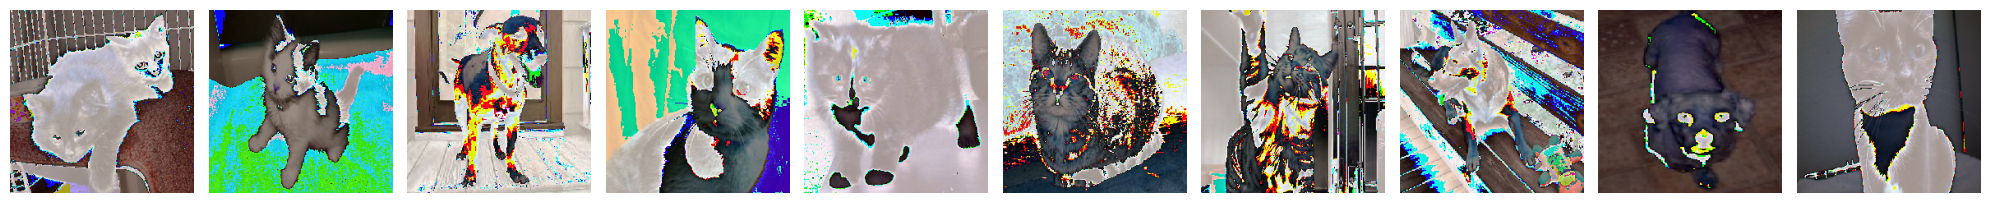

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


In [ ]:
imgs, labels = next(train_batches)
def plot_images(img_arr):
  fig, axes = plt.subplots(1, 10, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip(img_arr, axes):
    ax.imshow(img.astype('uint8'))
    ax.axis("off")
  plt.tight_layout()
  plt.show()

plot_images(imgs)
print(labels)

In [ ]:
model = Sequential(
    [
        Conv2D(filters=32, kernel_size=(3,3), activation="relu", padding="same", input_shape=(224, 224,3)),
        MaxPool2D(pool_size=(2,2), strides=2),
        Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding="same"),
        MaxPool2D(pool_size=(2,2), strides=2),
        Flatten(),
        Dense(units=2, activation="softmax")
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 2)                 4

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
# model.compile(optimizer=Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=5, verbose=2)

Epoch 1/5
100/100 - 175s - loss: 16.6131 - accuracy: 0.5290 - val_loss: 20.4757 - val_accuracy: 0.5200 - 175s/epoch - 2s/step
Epoch 2/5
100/100 - 4s - loss: 3.4749 - accuracy: 0.7290 - val_loss: 3.3064 - val_accuracy: 0.6150 - 4s/epoch - 45ms/step
Epoch 3/5
100/100 - 6s - loss: 0.7206 - accuracy: 0.8930 - val_loss: 3.4808 - val_accuracy: 0.6050 - 6s/epoch - 56ms/step
Epoch 4/5
100/100 - 5s - loss: 0.2029 - accuracy: 0.9560 - val_loss: 2.9041 - val_accuracy: 0.5750 - 5s/epoch - 48ms/step
Epoch 5/5
100/100 - 5s - loss: 0.1254 - accuracy: 0.9700 - val_loss: 2.8313 - val_accuracy: 0.6450 - 5s/epoch - 45ms/step


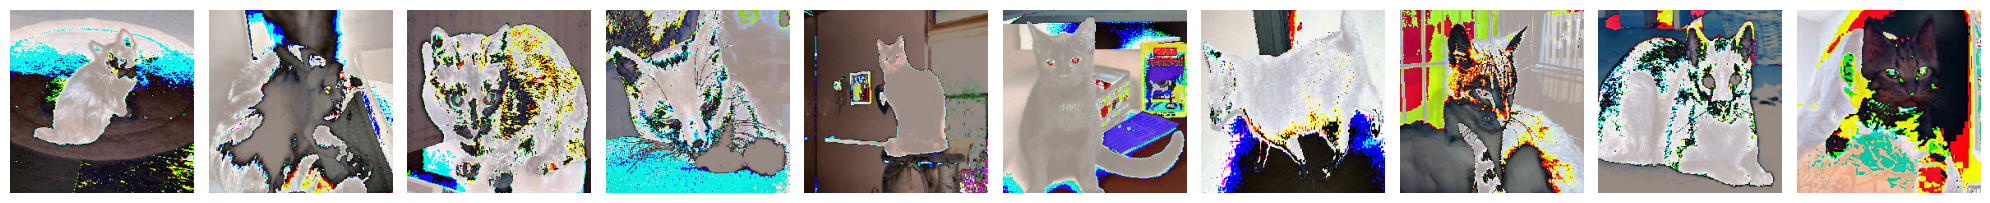

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [ ]:
test_imgs, test_labels = next(test_batches)
plot_images(test_imgs)
print(test_labels)

In [ ]:
pred = model.predict(x=test_batches, verbose=0)

In [ ]:
# Confusion matrix
def plot_conf_matrix(cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation="nearest", cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype("float")/ cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix no normalization")
  print(cm)
  thresh = cm.max()/2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

Confusion matrix no normalization
[[69 31]
 [39 61]]


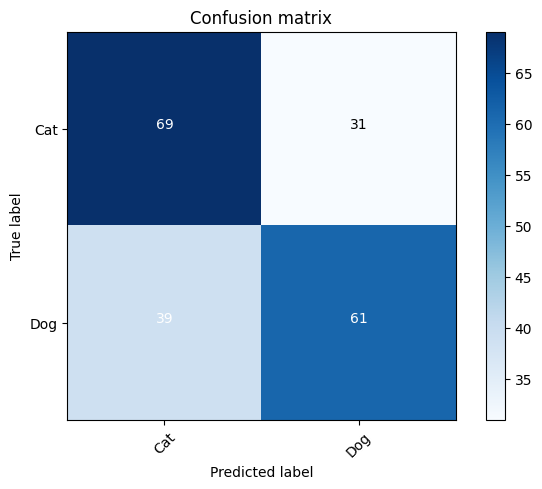

In [ ]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(pred, axis=-1))
cm_plot_labels = ["Cat", "Dog"]
plot_conf_matrix(cm=cm, classes=cm_plot_labels)

In [ ]:
vgg16_model = tf.keras.applications.vgg16.VGG16()
vgg16_model.summary()

553467096/553467096 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
def count_params(model):
  non_trainable_params = np.sum([np.prod(_.get_shape().as_list()) for _ in model.non_trainable_weights])
  trainable_params = np.sum([np.prod(_.get_shape().as_list()) for _ in model.trainable_weights])
  return {"non_trainable_params": non_trainable_params, "trainable_params": trainable_params}

In [ ]:
params = count_params(vgg16_model)
assert params["non_trainable_params"] == 0
assert params["trainable_params"] == 138357544

In [ ]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
  model.add(layer)
model.summary()

params = count_params(model)
assert params["non_trainable_params"] == 0
assert params["trainable_params"] == 134260544

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [ ]:
for layer in model.layers:
  layer.trainable = False

model.add(Dense(units=2, activation="softmax"))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [ ]:
params = count_params(model)
assert params["non_trainable_params"] == 134260544
assert params["trainable_params"] == 8194

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(x=train_batches, validation_data=valid_batches, epochs=5, verbose=2)

Epoch 1/5
100/100 - 8s - loss: 0.0191 - accuracy: 0.9970 - val_loss: 0.0605 - val_accuracy: 0.9700 - 8s/epoch - 82ms/step
Epoch 2/5
100/100 - 7s - loss: 0.0114 - accuracy: 0.9970 - val_loss: 0.0632 - val_accuracy: 0.9700 - 7s/epoch - 69ms/step
Epoch 3/5
100/100 - 7s - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.0620 - val_accuracy: 0.9700 - 7s/epoch - 70ms/step
Epoch 4/5
100/100 - 7s - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.0523 - val_accuracy: 0.9850 - 7s/epoch - 69ms/step
Epoch 5/5
100/100 - 7s - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0594 - val_accuracy: 0.9750 - 7s/epoch - 70ms/step


Confusion matrix no normalization
[[97  3]
 [ 3 97]]


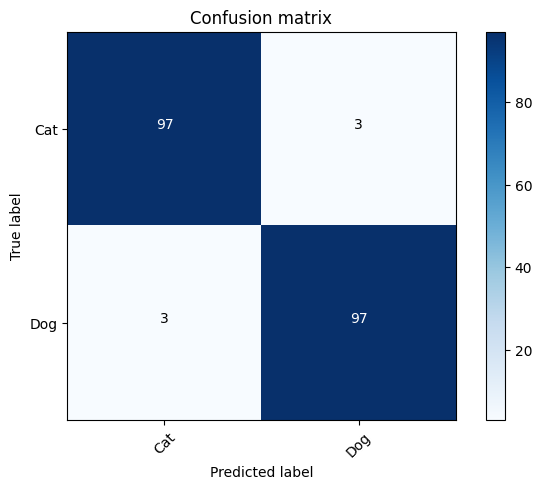

In [ ]:
pred = model.predict(x=test_batches, verbose=0)
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(pred, axis=-1))
cm_plot_labels = ["Cat", "Dog"]
plot_conf_matrix(cm=cm, classes=cm_plot_labels)

In [ ]:
os.chdir("../animals/")

In [ ]:
mobile = tf.keras.applications.mobilenet.MobileNet()

In [ ]:
def prep_image(file):
  img_path = "./"
  img = image.load_img(img_path + file, target_size=(224, 224))
  img_array = image.img_to_array(img)
  img_array_expanded_dims = np.expand_dims(img_array, axis=0)
  return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

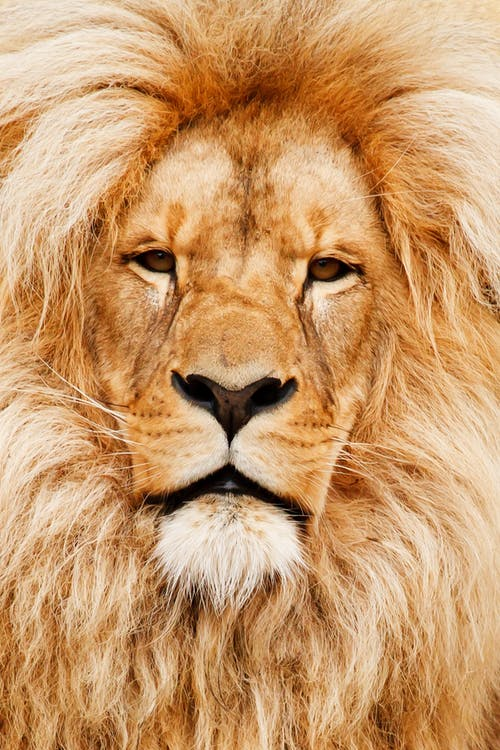

In [ ]:
Image(filename="africa-african-animal-cat-41315.jpeg", width=200, height=200)

In [ ]:
preprocessed_image = prep_image("africa-african-animal-cat-41315.jpeg")
pred = mobile.predict(preprocessed_image)
result = imagenet_utils.decode_predictions(pred)
result

1/1 [==============================] - 0s 21ms/step


[[('n02129165', 'lion', 0.9967368),
  ('n02112137', 'chow', 0.0030083447),
  ('n02086079', 'Pekinese', 9.33846e-05),
  ('n02108551', 'Tibetan_mastiff', 8.211116e-05),
  ('n02097474', 'Tibetan_terrier', 2.0593949e-05)]]

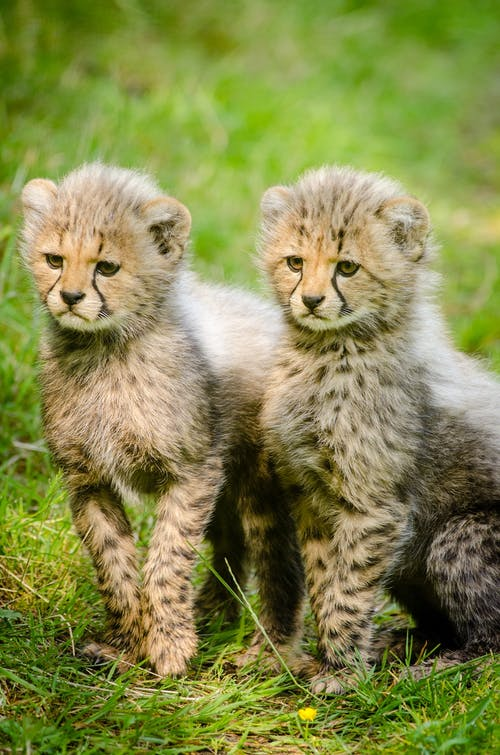

In [ ]:
Image(filename="cheetahs-cubs-two-together-162318.jpeg", width=200, height=200)

In [ ]:
preprocessed_image = prep_image("cheetahs-cubs-two-together-162318.jpeg")
pred = mobile.predict(preprocessed_image)
result = imagenet_utils.decode_predictions(pred)
result

1/1 [==============================] - 0s 50ms/step


[[('n02130308', 'cheetah', 0.5283749),
  ('n02127052', 'lynx', 0.41354847),
  ('n02119789', 'kit_fox', 0.017139096),
  ('n02124075', 'Egyptian_cat', 0.01420595),
  ('n02129165', 'lion', 0.0047380743)]]

In [ ]:
gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15,
                         zoom_range=0.1, channel_shift_range=10., horizontal_flip=True)
img_path = choice(os.listdir("./"))
image = np.expand_dims(plt.imread(img_path), 0)
plt.imshow(image[0])

In [ ]:
aug_iter = gen.flow(image)
aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]
plot_images(aug_images)